This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [16]:
# If haven't downloaded it yet, please get the data file with wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

--2021-11-30 23:16:54--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2021-11-30 23:16:55--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uceddeca1bcf0659b8c97471f2d0.dl.dropboxusercontent.com/cd/0/inline/Ba_Sxf1Cs4MGKruIDh0MHoLVqMKGl132Gr-JqlNbr66IA8jpRlkfBJYWQU84AczyQR98Tj4rwPCGjDRcyBS1ZgU3UcKmMWhoCSPEud9qpwDgRyq_nNwKo-vGnqvWSOK_J_QAIrVRh_gzxQj45bDJqah8/file# [following]
--2021-11-30 23:16:55--  https://uceddeca1bcf0659b8c97471f2d0.dl.dropboxusercontent.com/cd/0/inline/Ba_Sxf1Cs4MGKruIDh0MHoLVqMKGl132Gr-JqlNbr66IA8jpRlkfBJYWQU84AczyQR98Tj4rwPCGjDRcy

In [17]:
import pandas as pd
file_name = "/content/data/data_000637.txt"
data = pd.read_csv(file_name)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [18]:
import random
N = random.randint(10000,1310720)
print("N chosen",N)
df = pd.read_csv(file_name, nrows=N)
df

N chosen 916991


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
916986,1,0,59,3869208477,1746,29
916987,1,0,64,3869208477,1746,20
916988,1,0,17,3869208477,1772,17
916989,1,0,45,3869208477,1756,9


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [19]:
x = df['BX_COUNTER'].max()
print(x)

3563


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [20]:
time_elapsed = len(df.groupby('ORBIT_CNT').count())*x*25/10**9
print("time elapsed (s) = ",time_elapsed)
print("time elapsed in mn",time_elapsed/(60))
print("time elapsed in hours",time_elapsed/(60*60))

time elapsed (s) =  0.739946025
time elapsed in mn 0.01233243375
time elapsed in hours 0.0002055405625


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [21]:
df['time'] = df['ORBIT_CNT']*x*25+df['BX_COUNTER']*25+df['TDC_MEAS']*(25/30)
print("new column with the absolute time in ns:")
df

new column with the absolute time in ns:


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time
0,1,0,123,3869200167,2374,26,3.446490e+14
1,1,0,124,3869200167,2374,27,3.446490e+14
2,1,0,63,3869200167,2553,28,3.446490e+14
3,1,0,64,3869200167,2558,19,3.446490e+14
4,1,0,64,3869200167,2760,25,3.446490e+14
...,...,...,...,...,...,...,...
916986,1,0,59,3869208477,1746,29,3.446497e+14
916987,1,0,64,3869208477,1746,20,3.446497e+14
916988,1,0,17,3869208477,1772,17,3.446497e+14
916989,1,0,45,3869208477,1756,9,3.446497e+14


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [22]:
noisyTDC=df.groupby(['TDC_CHANNEL']).size().sort_values(ascending=False)
print(noisyTDC[0:3])

TDC_CHANNEL
139    75866
64     46085
63     45244
dtype: int64


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [23]:
non_empty = len(df.groupby('ORBIT_CNT').count())
print("Number of non-empty orbit",non_empty)


non_empty139=df[df['TDC_CHANNEL']==139].groupby('ORBIT_CNT').count()
print("number of unique orbits with at least one measurement from TDC_CHANNEL=139",len(non_empty139))


Number of non-empty orbit 8307
number of unique orbits with at least one measurement from TDC_CHANNEL=139 8282


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c061835d0>]],
      dtype=object)

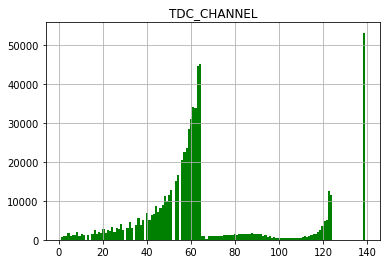

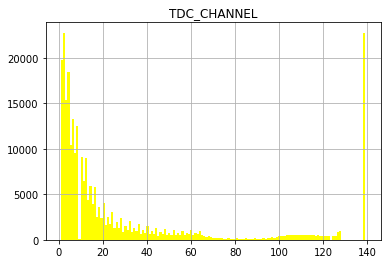

In [24]:
fpga0 = df.loc[df['FPGA'] == 0]
fpga1 = df.loc[df['FPGA'] == 1]

fpga0.hist(column='TDC_CHANNEL', bins= df['TDC_CHANNEL'].max(), color = 'green')
fpga1.hist(column='TDC_CHANNEL', bins= df['TDC_CHANNEL'].max(), color="yellow")

